In [1]:
import json
import math
import pytz
from datetime import datetime,timedelta,timezone
from dateutil.tz import tzutc
from dateutil.relativedelta import relativedelta
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import csv
from scipy.interpolate import interp1d
from scipy.stats import pearsonr, mode,skew,kurtosis
from scipy.signal import savgol_filter
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_squared_error,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from scipy.interpolate import UnivariateSpline
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import mean_squared_error as MSE

addDataPrefix='/Users/sorush/My Drive/Documents/Educational/TAMU/Research/Trial/Data/11-5-21-11-15-21'
if not os.path.exists(addDataPrefix):
    addDataPrefix='/home/grads/s/sorush.omidvar/CGMDataset/Trial/Data/11-5-21-11-15-21'
if not os.path.exists(addDataPrefix):
   addDataPrefix = 'C:\\GDrive\\Documents\\Educational\\TAMU\\Research\\Trial\\Data\\11-5-21-11-15-21'

addUserInput=os.path.join(addDataPrefix,'User inputted')
addHKCM=os.path.join(addDataPrefix,'hk+cm')
addCGM=os.path.join(addDataPrefix,'CGM')
addE4=os.path.join(addDataPrefix,'E4')

exempts=['p2']

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({'figure.facecolor':'white'})

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)

In [2]:

START_OF_TRIAL = datetime.strptime('11 06 2021-02:00:00', '%m %d %Y-%H:%M:%S')#to handle the daylight saving issue in apple watches
END_OF_TRIAL = datetime.strptime('11 15 2021-00:00:00', '%m %d %Y-%H:%M:%S')  

# if os.path.exists(os.path.join(addDataPrefix,'All_meals.pkl')):
#     os.remove(os.path.join(addDataPrefix,'All_meals.pkl'))
os.chdir(addUserInput)
if not os.path.exists(os.path.join(addDataPrefix,'All_meals.pkl')):    
    df=[]
    for root, dirs, files in os.walk(addUserInput):
        for file in files:
            if '.csv' in file.lower():
                if 'meals' in file.lower():
                    participantName=file[:file.find('Meals')]
                    if participantName in exempts:
                        print("Exemption...",file)
                        continue
                    print("Reading ...",file)
                    dfTemp = pd.read_csv(file)
                    dfTemp.insert(0,'Participant',participantName)
                    dfTemp.rename(columns={'startTime':'StartTime'}, inplace=True)
                    dfTemp['StartTime']=pd.to_datetime(dfTemp['StartTime'])
                    dfTemp['FinishTime']=pd.to_datetime(dfTemp['FinishTime'])

                    dfTemp['StartTime']-=pd.DateOffset(hours=5)#fixing the time zone issue
                    dfTemp['FinishTime']-=pd.DateOffset(hours=5)#fixing the time zone issue            
                    dfTemp.sort_values(["Participant",'StartTime'],ascending = (True, True),inplace=True)
                    if len(dfTemp.columns)!=10:
                        print("MAYDAY. Error in reading csv")
                        break
                    if len(df)!=0:
                        frames=[dfTemp,df]
                        df=pd.concat(frames)
                    else:
                        df=dfTemp
    print("reading is done")
    dfMeal=df    
    dfMeal=dfMeal[dfMeal['StartTime']>=START_OF_TRIAL]
    dfMeal=dfMeal[dfMeal['FinishTime']<END_OF_TRIAL]
    print("Meal database is limited to the trial period")
    dfMeal.to_pickle(os.path.join(addDataPrefix,'All_meals.pkl')) 
else:
    dfMeal=pd.read_pickle(os.path.join(addDataPrefix,'All_meals.pkl')) 

def pdInterpolation(dfTemp):
    index=dfTemp['Time']
    seriesParticipant = pd.Series(dfTemp['Abbot'].to_list(), index=index)
    seriesParticipant=seriesParticipant.resample('1T').asfreq()
    seriesParticipant.interpolate(method='polynomial',order=3,inplace=True)
    tempTime=seriesParticipant.index
    tempVal=seriesParticipant.values
    dfTemp=pd.DataFrame(zip(tempTime,tempVal),columns=['Time','Abbot'])
    return dfTemp

# if os.path.exists(os.path.join(addDataPrefix,'All_cgm.pkl')):
#     os.remove(os.path.join(addDataPrefix,'All_cgm.pkl'))
if not os.path.exists(os.path.join(addDataPrefix,'All_cgm.pkl')):
    os.chdir(addCGM)
    dfCGM=[]
    for root, dirs, files in os.walk(addCGM):
        for file in files:
            if '.txt' in file.lower():
                if '_fl' in file.lower():
                    participantName=file[:file.find('_fl')]
                    if participantName in exempts:
                        print("Exemption...",file)
                        continue
                    print("Reading ...",file)
                    dfTemp = pd.read_csv(file,sep="\t",skiprows=1)
                    if len(dfTemp.columns)!=4:
                        print("MAYDAY. Error in reading csv")
                        break               
                    dfTemp.columns.values[0] = "ID"
                    dfTemp.columns.values[1] = "Time"
                    dfTemp.columns.values[2] = "Record"
                    dfTemp.columns.values[3] = "Abbot"
                    dfTemp.drop(columns=["ID",'Record'],inplace=True)                
                    dfTemp['Time']=pd.to_datetime(dfTemp['Time'])
                    dfTemp['Abbot']=pd.to_numeric(dfTemp['Abbot'])
                    dfTemp.sort_values(["Time"],ascending = (True),inplace=True)
                    dfTemp=pdInterpolation(dfTemp)
                    dfTemp.insert(0,'Participant',participantName)
                    if len(dfTemp.columns)!=3:
                        print("MAYDAY. Error in processing csv")
                        break                    
                    if len(dfCGM)!=0:
                        frames=[dfTemp,dfCGM]
                        dfCGM=pd.concat(frames)
                    else:
                        dfCGM=dfTemp
    print("reading is done")
    dfCGM=dfCGM[dfCGM['Time']>=START_OF_TRIAL]
    dfCGM=dfCGM[dfCGM['Time']<END_OF_TRIAL]
    print("CGM database is limited to the trial period")
    dfCGM.to_pickle(os.path.join(addDataPrefix,'All_cgm.pkl')) 
else:
    dfCGM=pd.read_pickle(os.path.join(addDataPrefix,'All_cgm.pkl'))


  
# if os.path.exists(os.path.join(addDataPrefix,'All_cm.pkl')):
#     os.remove(os.path.join(addDataPrefix,'All_cm.pkl'))
os.chdir(addHKCM)
if not os.path.exists(os.path.join(addDataPrefix,'All_cm.pkl')):
    df=[]
    for root, dirs, files in os.walk(addHKCM):
        for file in files:
            if '.csv' in file.lower():
                if 'cm' in file.lower() and 'modified' in file.lower():
                    participantName=file[:file.find('_cm')]
                    if participantName in exempts:
                        print("Exemption...",file)
                        continue
                    print("Reading ...",file)
                    dfTemp=pd.read_csv(file)
                    print("File is read")
                    dfTemp['Time']=pd.to_datetime(dfTemp['Time'])
                    dfTemp.insert(0,'Participant',participantName)
                    dfTemp.insert(len(dfTemp.columns),'|Ax|+|Ay|+|Az|',dfTemp['Ax'].abs()+dfTemp['Ay'].abs()+dfTemp['Az'].abs()+0.001)#this is to avoid 0 later on for feature calculation
                    dfTemp.insert(len(dfTemp.columns),'|Yaw|+|Roll|+|Pitch|',dfTemp['Yaw'].abs()+dfTemp['Roll'].abs()+dfTemp['Pitch'].abs())
                    dfTemp.insert(len(dfTemp.columns),'RotationalToLinear',dfTemp['|Yaw|+|Roll|+|Pitch|']/dfTemp['|Ax|+|Ay|+|Az|'])
                    print("modified")
                    dfTemp.sort_values(['Time'],ascending = (True),inplace=True)
                    print("sorted")
                    if len(dfTemp.columns)!=14:
                        print("MAYDAY. Error in reading csv")
                        print(dfTemp.columns)
                        break
                    if len(df)!=0:
                        frames=[dfTemp,df]
                        df=pd.concat(frames)
                    else:
                        df=dfTemp
    dfCM=df
    print("Processing is done")
    dfCM=dfCM[dfCM['Time']>=START_OF_TRIAL]
    dfCM=dfCM[dfCM['Time']<END_OF_TRIAL]
    print("CM database is limited to the trial period")
    dfCM.to_pickle(os.path.join(addDataPrefix,'All_cm.pkl')) 
else:
    dfCM = pd.read_pickle(os.path.join(addDataPrefix,'All_cm.pkl'))


# if os.path.exists(os.path.join(addDataPrefix,'All_E4.pkl')):
#     os.remove(os.path.join(addDataPrefix,'All_E4.pkl'))
os.chdir(addE4)
# fields=['ACC','BVP','EDA','HR','IBI','TEMP']
fields=['BVP','EDA','HR','TEMP']
if not os.path.exists(os.path.join(addDataPrefix,'All_E4.pkl')):    
    dfE4=[]
    for root, dirs, files in os.walk(addE4):
        for file in files:
            if '.csv' in file.lower():
                participantName=root[root.find('E4')+3:]
                participantName=participantName[:2]
                field=file[:file.find('.csv')]
                if field not in fields:
                    print("File name does not comply with analyzed fields",file)
                    continue
                print(participantName,field)
                if participantName in exempts:
                    print("Exemption...",file)
                    continue
                print("Reading ...",file)
                os.chdir(root)
                dfTemp = pd.read_csv(file,header=None)
                # if field=='ACC':
                #     assert len(dfTemp.columns)==3
                #     timeBase=dfTemp.iloc[0,0]
                #     timeStep=1/dfTemp.iloc[1,0]
                #     dfTemp.drop([0,1],inplace=True)
                #     dfTemp.rename(columns={0:'Data1',1:'Data2',2:'Data3'}, inplace=True)#x,y,z for data1,data2,data3
                #     timeTemp=[]
                #     for counter in range(len(dfTemp)):
                #         timeTemp.append(timeBase+counter*timeStep)
                #     dfTemp.insert(0,'Time',timeTemp)
                #     dfTemp.insert(0,'Field',"Acceleration")
                #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                if field=='BVP':
                    assert len(dfTemp.columns)==1
                    timeBase=dfTemp.iloc[0,0]
                    timeStep=1/dfTemp.iloc[1,0]
                    dfTemp.drop([0,1],inplace=True)
                    dfTemp.rename(columns={0:'Data1'}, inplace=True)
                    dfTemp["Data2"]=""
                    dfTemp["Data3"]=""
                    timeTemp=[]
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase+counter*timeStep)
                    dfTemp.insert(0,'Time',timeTemp)
                    dfTemp.insert(0,'Field',"BVP")
                    dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                elif field=='HR':
                    assert len(dfTemp.columns)==1
                    timeBase=dfTemp.iloc[0,0]
                    timeStep=1/dfTemp.iloc[1,0]
                    dfTemp.drop([0,1],inplace=True)
                    dfTemp.rename(columns={0:'Data1'}, inplace=True)
                    dfTemp["Data2"]=""
                    dfTemp["Data3"]=""
                    timeTemp=[]
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase+counter*timeStep)
                    dfTemp.insert(0,'Time',timeTemp)
                    dfTemp.insert(0,'Field',"HR")
                    dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')                
                elif field=='EDA':
                    assert len(dfTemp.columns)==1
                    timeBase=dfTemp.iloc[0,0]
                    timeStep=1/dfTemp.iloc[1,0]
                    dfTemp.drop([0,1],inplace=True)
                    dfTemp.rename(columns={0:'Data1'}, inplace=True)
                    dfTemp["Data2"]=""
                    dfTemp["Data3"]=""                    
                    timeTemp=[]
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase+counter*timeStep)
                    dfTemp.insert(0,'Time',timeTemp)
                    dfTemp.insert(0,'Field',"EDA")
                    dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                # elif field=='IBI':
                #     assert len(dfTemp.columns)==2
                #     timeBase=dfTemp.iloc[0,0]
                #     dfTemp.drop([0],inplace=True)
                #     dfTemp.rename(columns={0:'Time',1:'Data1'}, inplace=True)
                #     dfTemp["Data2"]=""
                #     dfTemp["Data3"]=""
                #     timeTemp=[]
                #     dfTemp['Time']+=timeBase
                #     dfTemp.insert(0,'Field',"IBI")
                #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                elif field=='TEMP':
                    assert len(dfTemp.columns)==1
                    timeBase=dfTemp.iloc[0,0]
                    timeStep=1/dfTemp.iloc[1,0]
                    dfTemp.drop([0,1],inplace=True)
                    dfTemp.rename(columns={0:'Data1'}, inplace=True)
                    dfTemp["Data2"]=""
                    dfTemp["Data3"]=""                    
                    timeTemp=[]
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase+counter*timeStep)
                    dfTemp.insert(0,'Time',timeTemp)
                    dfTemp.insert(0,'Field',"Temperature")
                    dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')             
                dfTemp.insert(0,'Participant',participantName)

                dfTemp['Time']-=pd.DateOffset(hours=6)#Empatica records in GMT and also during the trial we had daylight saving
                dfTemp.sort_values(["Participant",'Field',"Time"],ascending = (True,True, True),inplace=True)
                if len(dfTemp.columns)!=6:
                    print("MAYDAY. Error in reading csv")
                    break
                if len(dfE4)!=0:
                    frames=[dfTemp,dfE4]
                    dfE4=pd.concat(frames)
                else:
                    dfE4=dfTemp
                
    print("reading is done")  
    dfE4=dfE4[dfE4['Time']>=START_OF_TRIAL]
    dfE4=dfE4[dfE4['Time']<END_OF_TRIAL]
    print("E4 database is limited to the trial period")
    dfE4.to_pickle(os.path.join(addDataPrefix,'All_E4.pkl')) 
else:
    dfE4=pd.read_pickle(os.path.join(addDataPrefix,'All_E4.pkl'))


In [16]:
MINIMUM_POINT_CM=100
OUTTER_WINDOW_LENGTH=timedelta(minutes=180)
OUTTER_WINDOW_STEP=timedelta(minutes=90)
EATING_PORTION=timedelta(minutes=90)
INNER_WINDOW_LENGTH=timedelta(minutes=1)


def e4Reporter(df):
    topics=['BVP','EDA','HR','Temperature']
    report=[]
    for topic in topics:
        dfTemp=df[df['Field']==topic]
        if(len(dfTemp)<MINIMUM_POINT_CM):
            report.append('Nan')
        else:
            val=dfTemp['Data1'].mean()
            report.append(val)
    return report

def motionCalculator(df):
    f1=df['RotationalToLinear'].mean()
    f2=df['|Ax|+|Ay|+|Az|'].mean()
    f5=df['|Yaw|+|Roll|+|Pitch|'].mean()
    return [f1,f2,f5]

def featureExtractor(dataList):
    dataList=np.asarray(dataList).astype(float)
    result=[]
    dataDim=dataList.ndim
    if dataDim>1:
        for counter in range(dataList.shape[1]):
            meanVal=np.nanmean(dataList[:,counter],axis=0)
            stdVal=np.nanstd(dataList[:,counter],axis=0)
            minVal=np.nanmin(dataList[:,counter],axis=0)
            maxVal=np.nanmax(dataList[:,counter],axis=0)
            rangeVal=maxVal-minVal
            # skewnessVal=skew(dataList[:,counter],nan_policy='omit',axis=0)
            # kurtosisVal=kurtosis(dataList[:,counter],nan_policy='omit',axis=0)
            result.extend([rangeVal, meanVal, stdVal, minVal, maxVal])
    else:
        meanVal=np.nanmean(dataList)
        stdVal=np.nanstd(dataList)
        minVal=np.nanmin(dataList)
        maxVal=np.nanmax(dataList)
        rangeVal=maxVal-minVal
        # skewnessVal=skew(dataList,nan_policy='omit')
        # kurtosisVal=kurtosis(dataList,nan_policy='omit')
        result.extend([rangeVal, meanVal, stdVal, minVal, maxVal])        
    return result


participants=dfCM['Participant'].to_list()
participants=list(set(participants))
participantDataList=[]
skippedWindows=0

# if os.path.exists(os.path.join(addDataPrefix,'Features.pkl')):
#     os.remove(os.path.join(addDataPrefix,'Features.pkl'))
if not os.path.exists(os.path.join(addDataPrefix,'Features.pkl')):
    for participant in participants:
        outterWindowStart=START_OF_TRIAL
        outterWindowEnd=outterWindowStart+OUTTER_WINDOW_LENGTH        
        print("Participant ",participant," is started")
        dfParticipantCM=dfCM[dfCM['Participant']==participant]
        dfParticipantMeal=dfMeal[dfMeal['Participant']==participant]
        dfParticipantCGM=dfCGM[dfCGM['Participant']==participant]
        dfParticipantE4=dfE4[dfE4['Participant']==participant]
        print("CM size for participant",len(dfParticipantCM))
        innerWindowStart=outterWindowStart
        innerWindowEnd=innerWindowStart+INNER_WINDOW_LENGTH        
        for i in tqdm(range(0,int(((END_OF_TRIAL-START_OF_TRIAL).total_seconds())/(OUTTER_WINDOW_LENGTH.total_seconds())),1)):
            dfTempMeal=dfParticipantMeal[(dfParticipantMeal['StartTime']>=outterWindowStart) & (dfParticipantMeal['StartTime']<=outterWindowStart+EATING_PORTION)]
            tempList=[]
            tempListCM=[]
            tempListE4=[]
            tempListCGM=[]
            tempListInfo=[outterWindowStart,outterWindowEnd,participant]
            skippedFlag=True
            for j in range(0,int((OUTTER_WINDOW_LENGTH.total_seconds())/(INNER_WINDOW_LENGTH.total_seconds())),1):
                dfTempCM=dfParticipantCM[(dfParticipantCM['Time']>=innerWindowStart) & (dfParticipantCM['Time']<innerWindowEnd)]
                if(len(dfTempCM)<MINIMUM_POINT_CM):
                    tempListCM.append(['Nan','Nan','Nan'])
                else:
                    tempListCM.append(motionCalculator(dfTempCM))

                dfTempE4=dfParticipantE4[(dfParticipantE4['Time']>=innerWindowStart) & (dfParticipantE4['Time']<innerWindowEnd)]
                if(len(dfTempE4)<MINIMUM_POINT_CM):
                    tempListE4.append(['Nan','Nan','Nan','Nan'])
                else:
                    tempListE4.append(e4Reporter(dfTempE4))
                
                if(len(dfTempCM)>MINIMUM_POINT_CM and len(dfTempE4)>MINIMUM_POINT_CM):
                    skippedFlag=False
                innerWindowStart+=INNER_WINDOW_LENGTH
                innerWindowEnd+=INNER_WINDOW_LENGTH
            if len(dfTempMeal)>0:
                mealFlag=1
            else:
                mealFlag=0
                
            carbs=dfTempMeal['Carbs'].sum()
            protein=dfTempMeal['Protein'].sum()
            fat=dfTempMeal['Fat'].sum()

            if skippedFlag:
                skippedWindows+=1
            else:
                assert len(tempListCM)==int((OUTTER_WINDOW_LENGTH.total_seconds())/(INNER_WINDOW_LENGTH.total_seconds()))
                tempListCM=featureExtractor(tempListCM)
                tempList.extend(tempListCM) #5*3=15

                assert len(tempListE4)==int((OUTTER_WINDOW_LENGTH.total_seconds())/(INNER_WINDOW_LENGTH.total_seconds()))
                tempListE4=featureExtractor(tempListE4)
                tempList.extend(tempListE4) #5*4=20

                dfTempCGM=dfParticipantCGM[(dfParticipantCGM['Time']>=outterWindowStart) & (dfParticipantCGM['Time']<outterWindowEnd)]
                tempListCGM=dfTempCGM['Abbot'].to_list()
                tempListCGM=featureExtractor(tempListCGM)
                tempList.extend(tempListCGM) #5

                tempList.extend(tempListInfo) #3
                tempList.append(carbs)
                tempList.append(fat)
                tempList.append(protein)
                tempList.append(mealFlag) #1
                assert len(tempList)==5*3+5*4+5+3+4
                participantDataList.append(tempList)
            outterWindowStart+=OUTTER_WINDOW_STEP
            outterWindowEnd+=OUTTER_WINDOW_STEP
    participantDataArray=np.asarray(participantDataList)
    columnTopics=['F1','F2','F5','BVP','EDA','HR','Temperature','CGM']
    columnStats=['Range','Mean','Std','Min','Max']
    columns=[]
    for topic in columnTopics:
        for stat in columnStats:
            columns.append(topic+stat)
    columns.extend(['Start','End','Participant','Carb','Fat','Protein','MealLabel'])
    dfFeatures=pd.DataFrame(participantDataArray,columns=columns)
    dfFeatures.to_pickle(os.path.join(addDataPrefix,'Features.pkl')) 
else:
    dfFeatures = pd.read_pickle(os.path.join(addDataPrefix,'Features.pkl'))


dfFeatures.reset_index(drop=True, inplace=True)
dropList=[]
print("Before addressing the leak:",len(dfFeatures))
for iteration in range(len(dfFeatures)):
    for counter in range(1,len(dfFeatures)):
        if(dfFeatures['MealLabel'].iloc[counter]==1):
            if(dfFeatures['Participant'].iloc[counter]==dfFeatures['Participant'].iloc[counter-1]):
                if(dfFeatures['Start'].iloc[counter]>=dfFeatures['Start'].iloc[counter-1]):
                    if(dfFeatures['Start'].iloc[counter]<=dfFeatures['End'].iloc[counter-1]):
                        # dropList.append(counter)
                        dfFeatures.drop(dfFeatures.index[counter],inplace=True)# To remove the data leak
                        dfFeatures.reset_index(drop=True, inplace=True)
                        break
print("After addressing the leak:",len(dfFeatures))




Before addressing the leak: 158
After addressing the leak: 119


In [21]:
print(dfMeal)

   Participant                              MealName           StartTime  \
3           p1                           Raspberries 2021-11-06 10:41:00   
4           p1                     Peruvian Sandwich 2021-11-06 12:00:00   
5           p1                             Ice cream 2021-11-06 12:20:00   
6           p1          Briscoe Bar + chocolate milk 2021-11-06 13:55:00   
7           p1                                 Pizza 2021-11-06 21:20:00   
8           p1                               Oatmeal 2021-11-08 07:36:00   
9           p1                               Avocado 2021-11-08 07:45:00   
10          p1                              Smoothie 2021-11-08 11:01:00   
11          p1                              Kind bar 2021-11-08 13:04:00   
12          p1                              Sandwich 2021-11-08 14:22:00   
13          p1                                 Snack 2021-11-08 17:29:00   
14          p1                              Kind bar 2021-11-08 21:38:00   
15          

In [9]:
def xgRegressor(xTrain,xVal,xTest,yTrain,yVal,yTest):
    rmseBest=100000000000
    for maxDepth in tqdm(np.arange(2,8,2)):
        for estimator in np.arange(50,200,50):
            clf = xgb.XGBClassifier(n_jobs=36,n_estimators=estimator,max_depth=maxDepth, objective = "reg:squarederror", eval_metric = "rmse")
            clf.fit(xTrain,yTrain)
            predictionsVal = clf.predict(xVal)
            rmse = np.sqrt(MSE(yVal, predictionsVal))
            if rmse<rmseBest:
                rmseBest=rmse
                modelBest=clf

    predictionsTest=modelBest.predict(xTest)
    rmse = np.sqrt(MSE(yTest, predictionsTest))
    # print("For ",parameter," we have RMSE:",rmse, "Relative RMSE:",rmse/np.sum(yTest))
    return rmse,rmse/np.sum(yTest),np.sum(yTest)
    # plot_confusion_matrix(modelBest, xTest, yTest,cmap='bone') 


def xgClassifier(xTrain,xVal,xTest,yTrain,yVal,yTest):
    f1ScoreBest=-1
    for maxDepth in tqdm(np.arange(2,8,2)):
        for estimator in np.arange(50,200,50):
            for posWeight in np.arange(1,10,2):
                clf = xgb.XGBClassifier(scale_pos_weight = posWeight, n_jobs=36,n_estimators=estimator,max_depth=maxDepth, objective = "binary:logistic", eval_metric = "error")
                clf.fit(xTrain,yTrain)
                predictionsVal = clf.predict(xVal)
        
                accuracy=sklearn.metrics.accuracy_score(yVal,predictionsVal)
                recall=sklearn.metrics.recall_score(yVal,predictionsVal)
                precision=sklearn.metrics.precision_score(yVal,predictionsVal)
                f1Score=sklearn.metrics.f1_score(yVal,predictionsVal)

                if f1Score>f1ScoreBest:
                    modelBest=clf
                    f1ScoreBest=f1Score
    predictionsTest=modelBest.predict(xTest)
    confMatrix=sklearn.metrics.confusion_matrix(yTest,predictionsTest)
    accuracy=sklearn.metrics.accuracy_score(yTest,predictionsTest)
    recall=sklearn.metrics.recall_score(yTest,predictionsTest)
    precision=sklearn.metrics.precision_score(yTest,predictionsTest)
    f1Score=sklearn.metrics.f1_score(yTest,predictionsTest)
    
    return accuracy,recall,precision,f1Score
    # plot_confusion_matrix(modelBest, xTest, yTest,cmap='bone') 

def dataBalancer(xTrain,xVal,yTrain,yVal):
    oversample = SMOTE()
    xVal, yVal = oversample.fit_resample(xVal, yVal)
    xTrain, yTrain = oversample.fit_resample(xTrain, yTrain)

    return xTrain,xVal,yTrain,yVal

def reportFormatter(reportTemp,classifierFlag,classifierReports,regressorReports,participant,combination,component):
    reportTemp=np.asarray(reportTemp)
    reportTemp=np.mean(reportTemp,axis=0)
    reportTemp=list(reportTemp)
    if classifierFlag:
        reportTemp.append(participant)
        reportTemp.append(combination)
        reportTemp.append('Nan')
        reportTemp=np.asarray(reportTemp)
        classifierReports.append(reportTemp)
    else:
        reportTemp.append('Nan')
        reportTemp.append(participant)
        reportTemp.append(combination)
        reportTemp.append(component)
        reportTemp=np.asarray(reportTemp)
        regressorReports.append(reportTemp)        

def testTrainSplitFunc(data,randomSeed,normalFlag,combination):
    participants=data[:,data.shape[1]-5]
    participants=list(set(participants))
    regressorReports=[]
    classifierReports=[]   
    for participantCounter in range(len(participants)+1):       
        
        indxList=[]
        if participantCounter<len(participants):
            participant=participants[participantCounter]
            print("Participant:",participant)
            for counter in range(data.shape[0]):
                if(data[counter,data.shape[1]-5]==participant):
                    indxList.append(counter)
            dataParticipant=data[indxList,:]
        else:#all participant
            participant="All"
            dataParticipant=data

        # windowStarts=dataParticipant[:,dataParticipant.shape[1]-7]
        # windowEnds=dataParticipant[:,dataParticipant.shape[1]-6]
        
        dataXBinary=dataParticipant[:,0:dataParticipant.shape[1]-7]
        dataXBinary=dataXBinary.astype(float)
        dataXRegression=dataXBinary

        dataYBinary=dataParticipant[:,dataParticipant.shape[1]-1]
        dataYBinary=dataYBinary.astype(float)

        dataYRegression=dataParticipant[:,dataParticipant.shape[1]-4:dataParticipant.shape[1]-1]#-4, -3 and -2 are carb, fat and protein
        dataYRegression=dataYRegression.astype(float)

        if(normalFlag):
            dataXBinary-=-dataXBinary.mean(axis=0)
            dataXBinary/=dataXBinary.std(axis=0)
            dataXRegression=dataXBinary        

        reportClassifierTemp=[]
        reportFatTemp=[]
        reportCarbTemp=[]
        reportProteinTemp=[]
        splitterOuter = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=randomSeed)
        for trainIndex, testIndex in splitterOuter.split(dataXBinary, dataYBinary):
            xTrainBinary,xTestBinary=dataXBinary[trainIndex,:],dataXBinary[testIndex,:]
            yTrainBinary,yTestBinary=dataYBinary[trainIndex],dataYBinary[testIndex]

            xTrainRegression,xTestRegression=dataXRegression[trainIndex,:],dataXRegression[testIndex,:]
            yTrainRegression,yTestRegression=dataYRegression[trainIndex,:],dataYRegression[testIndex,:]

            splitterInner = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=randomSeed)
            for trainIndex, valIndex in splitterInner.split(xTrainBinary, yTrainBinary):
                xTrainBinary,xValBinary=dataXBinary[trainIndex,:],dataXBinary[valIndex,:]
                yTrainBinary,yValBinary=dataYBinary[trainIndex],dataYBinary[valIndex]

                xTrainRegression,xValRegression=dataXRegression[trainIndex,:],dataXRegression[valIndex,:]
                yTrainRegression,yValRegression=dataYRegression[trainIndex,:],dataYRegression[valIndex,:]

            

            tempFilter=[]
            print(len(xTrainRegression),xTrainRegression.shape)
            os._exit()
            for counter in range(len(xTrainRegression)):
                print('')

            counter=0
            reportCarbTemp.append(xgRegressor(xTrainRegression,xValRegression,xTestRegression,yTrainRegression[:,counter],yValRegression[:,counter],yTestRegression[:,counter]))
            counter=1
            reportFatTemp.append(xgRegressor(xTrainRegression,xValRegression,xTestRegression,yTrainRegression[:,counter],yValRegression[:,counter],yTestRegression[:,counter]))
            counter=2
            reportProteinTemp.append(xgRegressor(xTrainRegression,xValRegression,xTestRegression,yTrainRegression[:,counter],yValRegression[:,counter],yTestRegression[:,counter]))            

            reportClassifierTemp.append(xgClassifier(xTrainBinary,xValBinary,xTestBinary,yTrainBinary,yValBinary,yTestBinary))
            

        reportFormatter(reportClassifierTemp,True,classifierReports,regressorReports,participant,combination,'Nan')
        reportFormatter(reportCarbTemp,False,classifierReports,regressorReports,participant,combination,'Carb')
        reportFormatter(reportFatTemp,False,classifierReports,regressorReports,participant,combination,'Fat')
        reportFormatter(reportProteinTemp,False,classifierReports,regressorReports,participant,combination,'Protein')
    classifierReports=np.asarray(classifierReports)
    regressorReports=np.asarray(regressorReports)
    comboReport=np.vstack((classifierReports,regressorReports))
    return comboReport

if os.path.exists(os.path.join(addDataPrefix,'FinalReport2.csv')):
    os.remove(os.path.join(addDataPrefix,'FinalReport2.csv'))
if not os.path.exists(os.path.join(addDataPrefix,'FinalReport2.csv')):
    combinations=[['CGM'],['CGM','F1','F2','F5'],['CGM','BVP','EDA','HR','Temperature'],['CGM','BVP','EDA','HR','Temperature','F1','F2','F3']]
    columns=dfFeatures.columns
    reportHeaders=['Accuracy-RMSE','Recall-RMSERelative','Precision-Macro','F1-NAN','Participant','Combination','Component']
    dfReports=[]
    for combination in combinations:
        columnList=['Start','End','Participant','Carb','Fat','Protein','MealLabel']
        for topic in combination:
            for column in columns:
                if topic in column:
                    columnList.append(column)
                    
        dfCombination = dfFeatures[dfFeatures.columns.intersection(columnList)]
        participantDataArray=dfCombination.to_numpy()
        randomSeed=random.randrange(50)
        print("----------------------")
        print("Combination:",'+'.join(combination))
        NORMALIZED_FLAG=False
        dfTemp=testTrainSplitFunc(participantDataArray,randomSeed,NORMALIZED_FLAG,'+'.join(combination))    
        dfTemp=pd.DataFrame(dfTemp,columns=reportHeaders)
        if len(dfReports)>0:
            frames=[dfTemp,dfReports]
            dfReports=pd.concat(frames)
        else:
            dfReports=dfTemp
    dfReports.reset_index(drop=True, inplace=True)
    print(dfReports)
    dfReports.to_csv(os.path.join(addDataPrefix,'FinalReport2.csv'),index=False)
else:
    dfReports=pd.read_csv(os.path.join(addDataPrefix,'FinalReport2.csv'))
# print("**********************************")
# print("**********************************")
# print("With NORMALIZATION")
# NORMALIZED_FLAG=True
# testTrainSplitFunc(participantDataArray,randomSeed,NORMALIZED_FLAG)

----------------------
Combination: CGM
Participant: p4
7 (7, 5)


TypeError: _exit() missing required argument 'status' (pos 1)

               CarbRMSE  CarbRMSERelative    FatRMSE  FatRMSERelative  \
Comboniation                                                            
C             14.968718          0.134809  11.418381         0.132723   
CEM           14.213007          0.118172  10.690259         0.116878   
CGM           13.031360          0.160182  12.116972         0.110248   
CM            15.029499          0.115402  11.771988         0.116773   

              ProteinRMSE  ProteinRMSERelative  
Comboniation                                    
C               12.975063             0.156886  
CEM              8.328241             0.115188  
CGM             10.172750             0.118285  
CM              12.237415             0.119656  


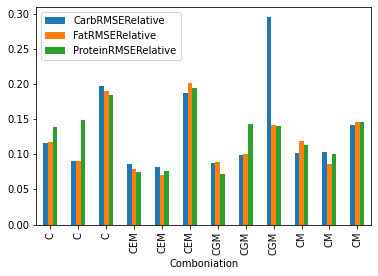

In [42]:
dfReports=pd.read_csv(os.path.join(addDataPrefix,'FinalReport.csv'))
dfReports.reset_index(drop=True, inplace=True)
dfReports.replace('Nan',np.nan,inplace=True)
dfReports.replace('CGM+BVP+EDA+HR+Temperature','C',inplace=True)
dfReports.replace('CGM+BVP+EDA+HR+Temperature','CE',inplace=True)
dfReports.replace('CGM+F1+F2+F5','CM',inplace=True)
dfReports.replace('CGM+BVP+EDA+HR+Temperature+F1+F2+F3','CEM',inplace=True)


dfRegression=dfReports.copy(deep=True)
dfRegression.drop(['Precision-Macro','F1-NAN'],axis=1,inplace=True)
dfRegression.dropna(inplace=True)

dfCarb=dfRegression.copy(deep=True)
dfProtein=dfRegression.copy(deep=True)
dfFat=dfRegression.copy(deep=True)

dfCarb=dfCarb[dfCarb['Component']=='Carb']
dfFat=dfFat[dfFat['Component']=='Fat']
dfProtein=dfProtein[dfProtein['Component']=='Protein']

dfCarb.sort_values(["Comboniation","Participant"],ascending = (True,True),inplace=True)
dfFat.sort_values(["Comboniation","Participant"],ascending = (True,True),inplace=True)
dfProtein.sort_values(["Comboniation","Participant"],ascending = (True,True),inplace=True)

dfCarb.reset_index(drop=True, inplace=True)
dfFat.reset_index(drop=True, inplace=True)
dfProtein.reset_index(drop=True, inplace=True)

assert len(dfCarb)==len(dfFat)
assert len(dfCarb)==len(dfProtein)

dfCarb.insert(len(dfCarb.columns),'CarbRMSE',-1)
dfCarb.insert(len(dfCarb.columns),'CarbRMSERelative',-1)

dfCarb.insert(len(dfCarb.columns),'FatRMSE',-1)
dfCarb.insert(len(dfCarb.columns),'FatRMSERelative',-1)

dfCarb.insert(len(dfCarb.columns),'ProteinRMSE',-1)
dfCarb.insert(len(dfCarb.columns),'ProteinRMSERelative',-1)

# for counter in range(len(dfCarb)):
dfCarb['CarbRMSE']=dfCarb['Accuracy-RMSE']
dfCarb['CarbRMSERelative']=dfCarb['Recall-RMSERelative']

dfCarb['FatRMSE']=dfFat['Accuracy-RMSE']
dfCarb['FatRMSERelative']=dfFat['Recall-RMSERelative']

dfCarb['ProteinRMSE']=dfProtein['Accuracy-RMSE']
dfCarb['ProteinRMSERelative']=dfProtein['Recall-RMSERelative']

dfCarb.drop(['Recall-RMSERelative','Accuracy-RMSE','Component'],axis=1,inplace=True)
dfCarb=dfCarb[dfCarb['Participant']!='All']


# dfCarb=dfCarb.groupby(['Comboniation']).mean()
# print(dfCarb)
# dfCarb.plot(kind='bar',x='Comboniation',y=['CarbRMSERelative','FatRMSERelative','ProteinRMSERelative'])
# print(dfCarb.groupby(['Participant']).mean())
print(dfCarb.groupby(['Comboniation']).mean())



# dfTemp=dfCarb[dfCarb['Participant']=='p3']
# participants=dfCarb['Participant'].to_list()
# participants=set(list(participants))
# for participant in participants:


# carb=dfTemp['CarbRMSERelative'].to_list()
# fat=dfTemp['FatRMSERelative'].to_list()
# protein=dfTemp['ProteinRMSERelative'].to_list()

In [68]:
participants= list(set(dfMeal['Participant'].to_list()))
for participant in participants:
    print(participant,"---------")
    dfTemp=dfMeal[dfMeal['Participant']==participant]
    duration=dfTemp['FinishTime']-dfTemp['StartTime']
    duration=duration.dt.seconds
    
    print(dfTemp['Carbs'].max(),dfTemp['Carbs'].min())
    # print(duration.mean()/60,duration.std()/60)
    # print(dfTemp['Carbs'].mean(),dfTemp['Carbs'].std())
    # print(dfTemp['Fat'].mean(),dfTemp['Fat'].std())
    # print(dfTemp['Protein'].mean(),dfTemp['Protein'].std())


p3 ---------
30.0 0.0
p4 ---------
123.0 0.0
p1 ---------
97.0 0.0
